## Minimizing Future Device Failures with Predictive Modeling
<p>

<font size="3"><b>High-level Summary:</b> </font>
<p>
<font size="2">Applying machine learning models to an arduous real-world, interdisciplinarity problem: predicting sensor device failures using attributes from related system and sub-system components.  A common thread among solving these types of problems is the popular machine learning algorithm’s ability to detect extremely rare events in a time series of highly noisy and non-normally-distributed data. Less than 0.0001% of the devices in this dataset (124,494 observations) will fail. One way to overcome noisy datasets such as this one is to use a popular method, SMOTE. The SMOTE algorithm generates new synthetic data from the minority class to increase its cardinality. Moreover, not all metrics should be used to demonstrate the performance of models used on imbalanced datasets. For this case study, device information, recorded device measurements (attributes 1-9), and time series are examined separately to determine what information equip the best predictive models. Popular algorithms tested for this case study include Logistic Regression, Ridge Regression, Isolation Forests, Long-Short Term Memory (LSTM), and a Support Vector Classifier (not shown, code provided). Popular literature suggest that using SMOTE for imbalanced datasets can be a reliable approach. Moreover, a random split was used for this study as apposed as a traditional time series training and holdout datasets. It is recommended to use a time series sampling strategy (plotted failures over time suggest there is a time series trend to device functionality), however it was not examined in this study.
<p>
The following modeling techniques were used with and without SMOTE in this case study:
<p>
    <li>Logistic Regression Modeling (with SMOTE) using device attributes</li>
    <li>Logistic Regression Modeling (without SMOTE) using device attributes</li>
    <li>Logistic Regression (with SMOTE) using One-Hot Encodings 'devices'</li>
    <li>Ridge Regression with Hyperparameter search (without SMOTE) using One-Hot Encodings 'devices'</li>
    <li>Ridge Regression with Hyperparameter search (with SMOTE) using One-Hot Encodings 'devices'</li>
    <li>Ridge Regression (without Hyperparameter search) (with SMOTE) using One-Hot Encodings 'devices'</li>
    <li>Isolation Forests using device attributes</li>
    <li>Tensorflow Autoencoder using an LSTM architecture</li>
    <li>Support Vector Classifier (code provided, output not shown due to computational ineffencies)</li></font>

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import f1_score

from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier

import h2o
from h2o.estimators import H2OIsolationForestEstimator

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from pylab import rcParams

from tensorflow import set_random_seed
set_random_seed(123)
rcParams['figure.figsize'] = 8, 6

In [6]:
#The Confusion Matrix (and F1-Score) will be the main model evaluator(s) for predicting on this imbalanced dataset

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

## Data Preparation

In [7]:
#Import Dataset
url = "http://aws-proserve-data-science.s3.amazonaws.com/device_failure.csv"
df = pd.read_csv(url, encoding = "ISO-8859-1")

#Sort dataset by date and device
df = df.sort_values(by = ['date', 'device'], ascending = True) #Sort by date and device

In [8]:
print("DataFrame attribute classes are: {}.".format(df.dtypes)) 
print(" ")
print("DataFrame dimensions are: {}.".format(df.shape))
print(" ")
mis = df.isnull().sum()
print("There are {} missing values.".format(mis))
print(" ")
print("There is {} duplicate value.".format(df.duplicated().sum())) #One duplicated row

DataFrame attribute classes are: date          object
device        object
failure        int64
attribute1     int64
attribute2     int64
attribute3     int64
attribute4     int64
attribute5     int64
attribute6     int64
attribute7     int64
attribute8     int64
attribute9     int64
dtype: object.
 
DataFrame dimensions are: (124494, 12).
 
There are date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64 missing values.
 
There is 1 duplicate value.


In [9]:
#Further Data Prep

#Format Date to datetime object
df['date'] = pd.to_datetime(df['date'],format='%Y/%m/%d') #format date to datetime

#Create Month and Day Columns
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day

#Create date_delta
df['date_delta'] = abs(df['date'] - datetime(2015, 11, 2)) #Subtract date from last date
df['date_delta'] = pd.to_numeric(df.date_delta, errors='coerce')

## EDA

In [10]:
# Attribute 1, 5, and 6 could contain readings from devices, where as the remainder are zero-inflated.
# The zero-inflated attributes could contain some type of measurement codes
print(df.describe())
print(df.corr())

             failure    attribute1     attribute2     attribute3  \
count  124494.000000  1.244940e+05  124494.000000  124494.000000   
mean        0.000851  1.223881e+08     159.484762       9.940455   
std         0.029167  7.045933e+07    2179.657730     185.747321   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%         0.000000  6.128476e+07       0.000000       0.000000   
50%         0.000000  1.227974e+08       0.000000       0.000000   
75%         0.000000  1.833096e+08       0.000000       0.000000   
max         1.000000  2.441405e+08   64968.000000   24929.000000   

          attribute4     attribute5     attribute6     attribute7  \
count  124494.000000  124494.000000  124494.000000  124494.000000   
mean        1.741120      14.222669  260172.657726       0.292528   
std        22.908507      15.943028   99151.078547       7.436924   
min         0.000000       1.000000       8.000000       0.000000   
25%         0.000000       8.000000  22145

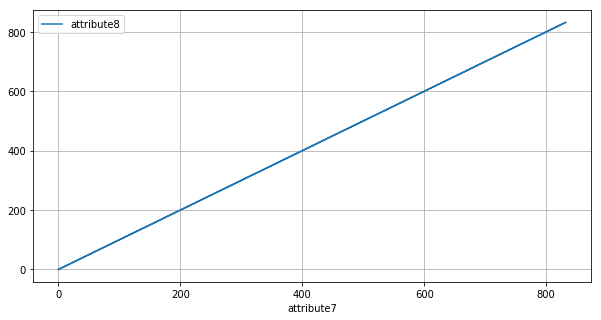

In [11]:
#Attribute 7 and attribute 8 are identical. Drop one for redundancy purposes. 
df.plot(x='attribute7', y='attribute8', figsize=(10,5), grid=True)
df = df.drop(['attribute8'], axis = 1)

In [12]:
# Less than 0.001% of the devices in this dataset (124,494 observations) will fail.
print(pd.crosstab(index=df["failure"],columns="count"))

print("")

# The timestamp intervals in this data set for devices ranged from 30 - 1163. 
# This suggest not all devices record at the same interval. 
# Predicting failures can require a more consistant timestamp interval of recorded measurements. 
print(pd.crosstab(index=df["date"],columns="count"))

col_0     count
failure        
0        124388
1           106

col_0       count
date             
2015-01-01   1163
2015-01-02   1163
2015-01-03   1163
2015-01-04   1162
2015-01-05   1161
2015-01-06   1054
2015-01-07    798
2015-01-08    756
2015-01-09    756
2015-01-10    755
2015-01-11    755
2015-01-12    755
2015-01-13    755
2015-01-14    716
2015-01-15    715
2015-01-16    715
2015-01-17    715
2015-01-18    714
2015-01-19    713
2015-01-20    713
2015-01-21    712
2015-01-22    712
2015-01-23    712
2015-01-24    712
2015-01-25    712
2015-01-26    712
2015-01-27    712
2015-01-28    712
2015-01-29    715
2015-01-30    712
...           ...
2015-10-02    146
2015-10-03    146
2015-10-04    146
2015-10-05    146
2015-10-06    141
2015-10-07    141
2015-10-08    141
2015-10-09    141
2015-10-10    140
2015-10-11    140
2015-10-12    140
2015-10-13    111
2015-10-14    111
2015-10-15    109
2015-10-16    109
2015-10-17    109
2015-10-18    109
2015-10-19    109
2015-10-20     69

In [13]:
#Find and sort devices, count by date aggregate by device.
date_tot = pd.DataFrame(df.groupby('device')['date'].count())
date_tot = date_tot.sort_values(by = ['date'], ascending = True) #Sort by date count
date_tot.reset_index(level=0, inplace=True)
date_tot = date_tot.rename(columns = {'date': 'date_total'})
date_tot

#Merge date totals with df
#Possible predictive information in date counts
df = df.merge(date_tot, left_on='device', right_on='device')
#print(df.head())

In [14]:
#Find and sort devices, count by date aggregate by device.
fail_tot = pd.DataFrame(df.groupby('date')['failure'].count())
fail_tot = fail_tot.sort_values(by = ['failure'], ascending = True) #Sort by date count
fail_tot.reset_index(level=0, inplace=True)
fail_tot = fail_tot.rename(columns = {'failure': 'failure_total'})

#Merge failure totals with df
#Possible predictive information in date counts
df = df.merge(fail_tot, left_on='date', right_on='date')
#print(df.head())

In [15]:
#Devices do not fail twice.
print("False = failure <= 1. True = failure > 1.")
df.groupby(['device'])['failure'].sum().gt(1).any()

False = failure <= 1. True = failure > 1.


False

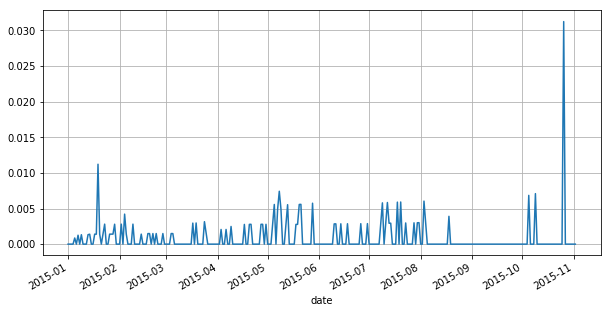

In [16]:
#Failures over time
fail_timeline = df.groupby('date').failure.sum() / df.groupby('date').failure.count()
fail_timeline.plot(figsize=(10,5), grid=True)

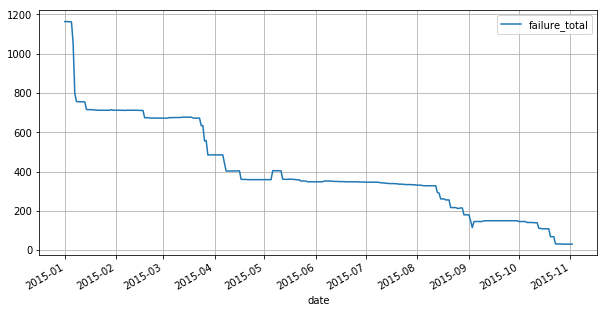

In [17]:
fail_tot.plot(y='failure_total', x='date', figsize=(10,5), grid=True)

In [18]:
#Create dummy matrix for devices in-case the time component (variable date_delta, month, or day) is too strong
df2 = pd.concat([df, pd.get_dummies(df['device'])], axis=1)
df2 = df2.drop(['device'], axis = 1)

## Divide the data into train and test

In [19]:
# Separate input features (X) and target variable (y)
y = df.failure
X = df.drop(['failure', 'device', 'date', 'failure_total', 'date_total', 'month', 'day'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 1234) 
print("The dimensions of the X and y training datasets:")
print(X_train.shape, y_train.shape)
print(" ")
print("The dimensions of the X and y test datasets:")
print(X_test.shape, y_test.shape)

The dimensions of the X and y training datasets:
(99595, 9) (99595,)
 
The dimensions of the X and y test datasets:
(24899, 9) (24899,)


In [20]:
m1_smote = SMOTE(ratio=1.0, random_state=1234)
X_train_smote, y_train_smote = m1_smote.fit_sample(X_train, y_train)

print("The dimensions of the X and y SMOTE training datasets:")
print(X_train_smote.shape, y_train_smote.shape)

The dimensions of the X and y SMOTE training datasets:
(199014, 9) (199014,)


## Modeling

<font size="3"><b>Logistic Regression Modeling with SMOTE<b></font>

The main metrics are not purposeful for model eval, but look to the confusion matrix
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24881
           1       0.00      0.00      0.00        18

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



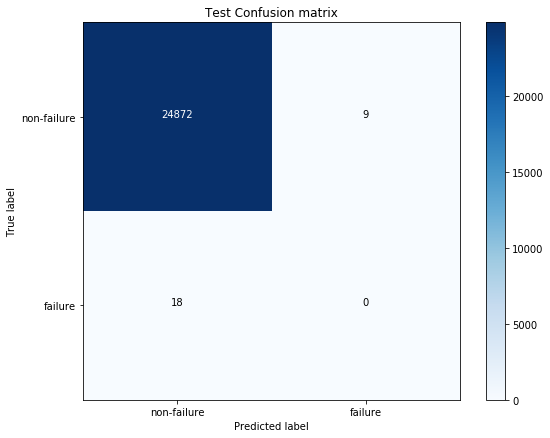

['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9', 'date_delta']
[[ 4.35560356e-26  3.54897268e-29 -6.73079050e-32  5.26164162e-31
   1.14380656e-32  8.67419528e-29  2.60599008e-31  1.35324830e-31
  -1.03763826e-18]]


In [21]:
m1 = LogisticRegressionCV(cv = 5)
m1.fit(X_train_smote, y_train_smote)
pred_m1 = m1.predict(X_test)

print("The main metrics are not purposeful for model eval, but look to the confusion matrix")
print(metrics.classification_report(y_test, pred_m1))

m1_cm = confusion_matrix(y_test, pred_m1)
plt.figure()
plot_confusion_matrix(m1_cm, title ='Test Confusion matrix', classes = ["non-failure","failure"])
plt.show()
print(list(X_train.columns))
print(m1.coef_)

<font size="3"><b>Logistic Regression Modeling (without SMOTE)</b></font>

The main metric are not purposeful for model eval, but look to the confusion matrix
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24881
           1       0.00      0.00      0.00        18

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


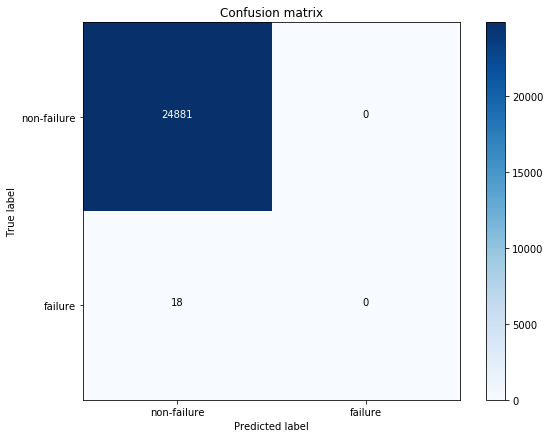

In [22]:
m2 = LogisticRegressionCV(cv = 5)
m2.fit(X_train, y_train)
pred_m2 = m2.predict(X_test)

print("The main metric are not purposeful for model eval, but look to the confusion matrix")
print(metrics.classification_report(y_test, pred_m2))

m2_cm = confusion_matrix(y_test, pred_m2)
plt.figure()
plot_confusion_matrix(m2_cm, title ='Confusion matrix', classes = ["non-failure","failure"])
plt.show()

## <font size="3"><b>Replacing Time-Based Variables for Devices One Hot Encodings</b></font>

In [23]:
# Separate input features (X) and target variable (y)
y2 = df2.failure
X2 = df2.drop(['failure', 'date', 'failure_total', 'date_total', 'month', 'day', 'date_delta'], axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.20, random_state = 1234) 

m2_smote = SMOTE(ratio=1.0, random_state=1234)
X_train_smote2, y_train_smote2 = m2_smote.fit_sample(X_train2, y_train2)

print("The dimensions of the second SMOTE X and y training datasets:")
print(X_train_smote2.shape, y_train_smote2.shape)

The dimensions of the second SMOTE X and y training datasets:
(199014, 1177) (199014,)


<font size="3"><b>Logistic Regression (with SMOTE) using One-Hot Encodings 'devices'</b></font>

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     24881
           1       0.01      0.44      0.02        18

    accuracy                           0.97     24899
   macro avg       0.50      0.71      0.50     24899
weighted avg       1.00      0.97      0.98     24899

This accuracy measure of 0.9663841921362304 doesn't mean much here, but look to the confusion matrix


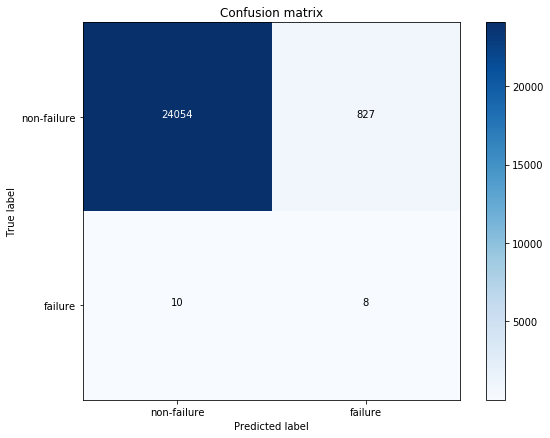

In [24]:
m3 = LogisticRegressionCV(cv = 5)
m3.fit(X_train_smote2, y_train_smote2)
pred_m3 = m3.predict(X_test2)

m3_acc = accuracy_score(y_test2, pred_m3)

print(metrics.classification_report(y_test2, pred_m3))
print("This accuracy measure of {} doesn't mean much here, but look to the confusion matrix".format(m3_acc))

m3_cm = confusion_matrix(y_test2, pred_m3)
plt.figure()
plot_confusion_matrix(m3_cm, title ='Confusion matrix', classes = ["non-failure","failure"])
plt.show()

## <font size="3"><b>Ridge Regression with Hyperparameter search (without SMOTE) using One-Hot Encodings 'devices'</b></font>

In [25]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge = RidgeClassifier()
m4 = GridSearchCV(ridge, parameters, cv = 5)

m4.fit(X_train2, y_train2)

pred_m4 = m4.predict(X_test2)

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.528541408359786e-36 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5262748094448195e-36 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.5273180296921076e-36 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.903270493629525e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.887703305636136e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 8.88424669582502e-22 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be acc

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24881
           1       0.00      0.00      0.00        18

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899

This accuracy measure of 0.9992770794007791 doesn't mean much here, but look to the confusion matrix


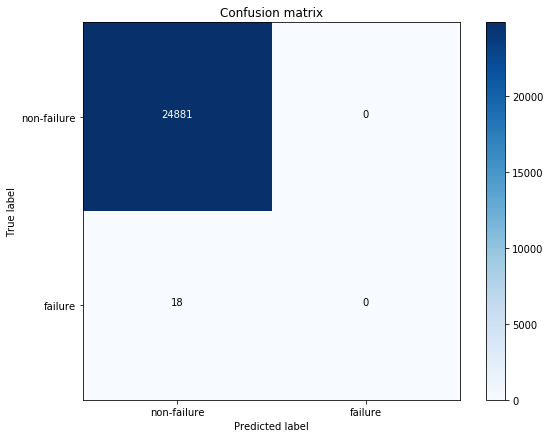

{'alpha': 1}


In [26]:
m4_acc = accuracy_score(y_test2, pred_m4)

print(metrics.classification_report(y_test2, pred_m4))
print("This accuracy measure of {} doesn't mean much here, but look to the confusion matrix".format(m4_acc))

m4_cm = confusion_matrix(y_test2, pred_m4)
plt.figure()
plot_confusion_matrix(m4_cm, title ='Confusion matrix', classes = ["non-failure","failure"])
plt.show()

<font size="3"><b>Ridge Regression with Hyperparameter search (with SMOTE) using One-Hot Encodings 'devices'</b></font>

In [27]:
alpha = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

ridge = RidgeClassifier()
m4_1 = GridSearchCV(ridge, parameters, cv=5)

m4_1.fit(X_train_smote2, y_train_smote2)

pred_m4_1 = m4_1.predict(X_test2)

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2890588918105794e-36 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2872086521645302e-36 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2895647780820957e-36 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2890588918105795e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2872086521645303e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.289564778082096e-21 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24881
           1       0.00      0.00      0.00        18

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899

This accuracy measure of 0.9992770794007791 doesn't mean much here, but look to the confusion matrix


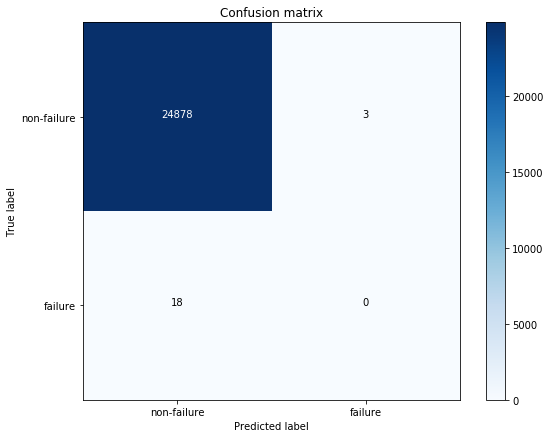

{'alpha': 1}


In [28]:
m4_1_acc = accuracy_score(y_test2, pred_m4_1)

print(metrics.classification_report(y_test2, pred_m4_1))
print("This accuracy measure of {} doesn't mean much here, but look to the confusion matrix".format(m4_acc))

m4_1_cm = confusion_matrix(y_test2, pred_m4_1)
plt.figure()
plot_confusion_matrix(m4_1_cm, title ='Confusion matrix', classes = ["non-failure","failure"])
plt.show()

<font size="3"><b>Ridge Regression (without Hyperparameter search) (with SMOTE) using One-Hot Encodings 'devices'</b></font>

/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.853843638136321e-22 / 1.1102230246251565e-16
  RuntimeWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24881
           1       0.00      0.00      0.00        18

    accuracy                           1.00     24899
   macro avg       0.50      0.50      0.50     24899
weighted avg       1.00      1.00      1.00     24899

This accuracy measure of 0.9991565926342424 doesn't mean much here, but look to the confusion matrix


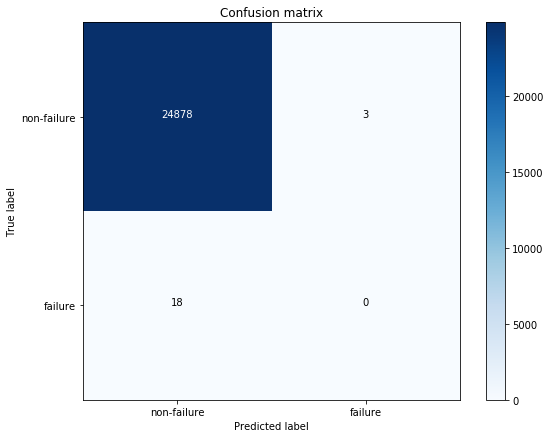

In [29]:
m5 = RidgeClassifier(random_state = 1234)
m5.fit(X_train_smote2, y_train_smote2)
pred_m5 = m5.predict(X_test2)

m5_acc = accuracy_score(y_test2, pred_m5)

print(metrics.classification_report(y_test2, pred_m5))
print("This accuracy measure of {} doesn't mean much here, but look to the confusion matrix".format(m5_acc))

m5_cm = confusion_matrix(y_test2, pred_m5)
plt.figure()
plot_confusion_matrix(m5_cm, title ='Confusion matrix', classes = ["non-failure","failure"])
plt.show()

## <font size="3"><b>Using H2O.ai for Isolation Forests (requries further tuning)</b></font>

In [ ]:
#Call H2o.ai API
h2o.init()

In [26]:
h_train = pd.concat([X_train, y_train], axis=1)
h_test = pd.concat([X_test, y_test], axis=1)
h_train = h2o.H2OFrame(h_train)
h_test = h2o.H2OFrame(h_test)

h_columns = ['attribute1','attribute2','attribute3','attribute4',
             'attribute5','attribute6','attribute7','attribute9']

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [27]:
# Build an Isolation forest model
m6 = H2OIsolationForestEstimator(ntrees = 200, sample_rate = 0.01, max_depth = 20)
m6.train(x = h_columns, training_frame = h_train)
print("m4 trained")
# Calculate score
m6_pred = m6.predict(h_test)

isolationforest Model Build progress: |███████████████████████████████████| 100%
m4 trained
isolationforest prediction progress: |████████████████████████████████████| 100%


In [28]:
quantile = 0.95
quantile_frame = m6_pred.quantile([quantile])
print(quantile_frame)

threshold = quantile_frame[0, "predictQuantiles"]
m6_pred["predicted"] = m6_pred["predict"] > threshold
m6_pred["actuals"] = h_test["failure"]
print(m6_pred.head()) #mean_length showing the ave # of splits across all trees to isolate the observation.

Probs,predictQuantiles,mean_lengthQuantiles
0.95,0.523364,15.775


predict,mean_length,predicted,actuals
0.36486,11.415,0,0
0.170841,14.01,0,0
0.344299,11.69,0,0
0.16,14.155,0,0
0.17757,13.92,0,0
0.225421,13.28,0,0
0.209346,13.495,0,0
0.109533,14.83,0,0
0.0414953,15.74,0,0
0.0657944,15.415,0,0


## <font size="3"><b>LSTM Autoencoder</b></font>

In [30]:
#Initialize data for LSTM Autoencoder using only the 8 selected attributes and date_delta variable

input_X = X.loc[:, X.columns].values  # converts the df to a numpy array
input_y = df['failure'].values

n_features = input_X.shape[1]  # number of features
print(X.columns)

Index(['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5',
       'attribute6', 'attribute7', 'attribute9', 'date_delta'],
      dtype='object')


In [31]:
def temporalize(X, y, past_obs):
    X = []
    y = []
    for i in range(len(input_X)-past_obs-1):
        t = []
        for j in range(1,past_obs+1):
            # Gather past records upto the past_obs period
            t.append(input_X[[(i+j+1)], :])
        X.append(t)
        y.append(input_y[i+past_obs+1])
    return X, y

In [32]:
# Past_obs should correspond to some time interval for dates, hours, minutes, seconds
# The collected data does not have equal intervals, so we will look at the past 20 observations

past_obs = 20

X, y = temporalize(X = input_X, y = input_y, past_obs = 20)

In [33]:
# Some more data splitting, specific to the LSTM Encoder

data_split = 0.2

X_train3, X_test3, y_train3, y_test3 = train_test_split(np.array(X), np.array(y), test_size = data_split, random_state = 1234)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train3, y_train3, test_size = data_split, random_state = 1234)

print(X_train3.shape)

X_train_y0 = X_train3[y_train3 == 0]
X_train_y1 = X_train3[y_train3 == 1]

X_valid_y0 = X_valid3[y_valid3 == 0]
X_valid_y1 = X_valid3[y_valid3 == 1]

print(X_train_y0.shape)

(79662, 20, 1, 9)
(79587, 20, 1, 9)


In [34]:
#Shaping 4D tensors to 3D tensors

X_train3 = X_train3.reshape(X_train3.shape[0], past_obs, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], past_obs, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], past_obs, n_features)

X_test3 = X_test3.reshape(X_test3.shape[0], past_obs, n_features)

X_valid3 = X_valid3.reshape(X_valid3.shape[0], past_obs, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], past_obs, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], past_obs, n_features)

In [36]:
#Function flattens 3D to 2D array of shape
def flatten(X):
    flat_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flat_X[i] = X[i, (X.shape[1]-1), :]
    return(flat_X)

#Function to standardize the data / standardize the training and test individually to better control for data leakage
def standardize(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])      
    return X

In [37]:
# Create the the scaler 
scaler = StandardScaler().fit(flatten(X_train_y0))

#Standardize training, validation set, and testset individually to better control for data leakage
X_train_y0_scaled = standardize(X_train_y0, scaler)
X_train_y1_scaled = standardize(X_train_y1, scaler)
X_train_scaled = standardize(X_train3, scaler)

In [44]:
#Testing to see if the mean and variances are between 0 and 1
test_flatten = flatten(X_train_y0_scaled)
print(np.mean(test_flatten, axis = 0))
print(np.var(test_flatten, axis = 0))

[-0.00103032  0.05838893  0.04324827  0.0558257   0.21017252  0.01299207
  0.03529471  0.04515813 -0.06179401]
[0.42293233 0.91461755 0.93672509 0.91011053 0.61082142 0.52559546
 0.95605887 0.92263437 0.48869912]


In [45]:
X_valid_scaled = standardize(X_valid3, scaler)
X_valid_y0_scaled = standardize(X_valid_y0, scaler)
X_test_scaled = standardize(X_test3, scaler)

In [49]:
#Building the LSTM Autoencoder

time_steps = X_train_y0_scaled.shape[1] 
n_features = X_train_y0_scaled.shape[2]

epochs = 500
batchsize = 64
learning_rate = 0.01

lstm_autoencoder = Sequential()

# Encoder
lstm_autoencoder.add(LSTM(time_steps, activation = 'relu', input_shape = (time_steps, n_features), return_sequences = True))
lstm_autoencoder.add(LSTM(9, activation = 'relu', return_sequences = True))
lstm_autoencoder.add(LSTM(1, activation = 'relu'))
lstm_autoencoder.add(RepeatVector(time_steps))

# Decoder
lstm_autoencoder.add(LSTM(time_steps, activation = 'relu', return_sequences = True))
lstm_autoencoder.add(LSTM(9, activation = 'relu', return_sequences = True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 20, 20)            2400      
_________________________________________________________________
lstm_10 (LSTM)               (None, 20, 9)             1080      
_________________________________________________________________
lstm_11 (LSTM)               (None, 1)                 44        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 20, 1)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 20)            1760      
_________________________________________________________________
lstm_13 (LSTM)               (None, 20, 9)             1080      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 9)             90        
Total para

In [ ]:
# Using a Tesla V100 to run this model - so the training time is not hardware-related, requires further research.
adam = optimizers.Adam(learning_rate)
lstm_autoencoder.compile(loss = 'mse', optimizer = adam)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, epochs = epochs, batch_size = batchsize, 
                                                validation_data = (X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose = 2).history

Train on 79587 samples, validate on 19900 samples
Epoch 1/500
 - 228s - loss: 0.7671 - val_loss: 0.7667
Epoch 2/500
 - 223s - loss: 122.5476 - val_loss: 0.7682
Epoch 3/500


In [ ]:
# m1 = SVC(kernel='linear', class_weight='balanced', probability=True)
# m1.fit(X_train, y_train)  
# y_pred = m1.predict(X_test) #Use for confusion matrix
# y_pred_train = m1.predict(X_train) #Use for training confusion matrix
# y_pred_p = m1.predict_proba(X_test) 
# y_pred_p = [p[1] for p in y_pred_p] 
 
# #Find metrics and AUROC
# print(classification_report(y_test,y_pred)) 
# print(confusion_matrix(y_train,y_pred_train))  
# print(confusion_matrix(y_test,y_pred))  
# print(roc_auc_score(y_test, y_pred_p))

## Best Model

Best Model: Logistic Regression (without SMOTE) using One-Hot Encodings 'devices'

Using a standard Logistic Regression Model predicted 44% of the failures in the testset
However it had an overwelming number of FP.


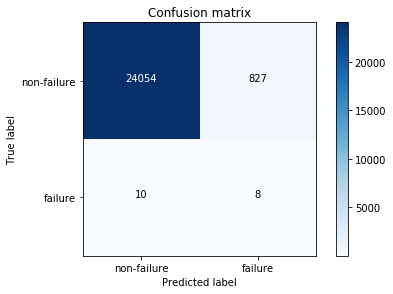

In [27]:
print("Best Model: Logistic Regression (without SMOTE) using One-Hot Encodings 'devices'")
print("")
print("Using a standard Logistic Regression Model predicted 44% of the failures in the testset")
print("However it had an overwelming number of FP.")
plt.figure()
plot_confusion_matrix(m3_cm, title ='Confusion matrix', classes = ["non-failure","failure"])
plt.show()

## Recommendations or Next Steps
<p>
<font size="3"><b>High-level Summary:</b> </font>
<ul><font size="2">
<li> Continue exploring attribute and device behavior before exploring predictive modeling techniques (individual device failure probabilities, relationships between devices, assumed measurement (attributes 1, 5, and 6) and recorded codes (remaining attributes). </li>
<li>Sampling for Time Series: The next series of models must be tested using non-randomized time series moving windows for the training and holdout set. See picture below for time series strategies. </li>
<li>Determine a better KPI: For each model, calculate KPI (TP/(TP+FN+FP) for a range of threshold to output 1s for the computed probabilities. Select the threshold and parameters for the best KPI for each model (objective to better minimize False Positives and maximize True Positives. Pick the model with the best KPI </li>
<li>Unknown devices: Determine what system, subsystem(s), devices, and measurements (attributes 1-9) are and what they are recording. </li>
<li>Generalize models: Optimize model generalization by using cross-system / subsystem machine learning resampling or splitting. Predictive models used on this training and test dataset should are assumed to consist of all data that make up of a single manufacture's system. The ability of the algorithms applied on this dataset could be effective across a range of systems if it has similar specifications and applications. </li>
<li>Try other using other model types: Support Vector Classifier with H2o.GPU (a simple SVC was ran on a Tesla P100 and was found computationally inefficient), Long Short Term Memory (LSTM), Autoencoder Neural Networks, or Survival Modeling. </li>
</ul></font>  

In [28]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://i.ibb.co/qdsScdC/Time-Series-Splitting.png", width=700, height=700)